In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
np.set_printoptions(precision=2)
plt.rcParams["figure.figsize"] = (10,10)

### load data

In [11]:
df = pd.read_pickle("/data/workspace_files/all_session.pkl") 
df.head()

combined_eye_closure 
 left_image_eye_closure 
 right_image_eye_closure 
 combined_eye_state 
 left_image_eye_state 
 right_image_eye_state 
 subject_id 
 session_id 
 session_type 
 perclos_closed_combined 
 perclos_combined_60s_interval 
 max_blink_duration_60s_interval 
 min_blink_duration_60s_interval 
 mean_blink_duration_60s_interval 
 blink_counts_60s_interval 
 karolinska_response_nearest_interpolation 
 karolinska_response_linear_interpolation 
 
 
 filename 
 frame 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 001_1_a 
 0 
 0.26 
 0.25 
 0.28 
 0 
 0 
 0 
 1 
 1 
 0 
 False 
 <NA> 
 <NA> 
 <NA> 
 NaN 
 <NA> 
 6 
 6 
 
 
 1 
 0.27 
 0.22 
 0.31 
 0 
 0 
 0 
 1 
 1 
 0 
 False 
 <NA> 
 <NA> 
 <NA> 
 NaN 
 <NA> 
 6 
 6 
 
 
 2 
 0.27 
 0.23 
 0.32 
 0 
 0 
 0 
 1 
 1 
 0 
 False 
 <NA> 
 <NA> 
 <NA> 
 NaN 
 <NA> 
 6 
 6 
 
 
 3 
 0.27 
 0.22 
 0.32 
 0 
 0 
 0 
 1 
 1 
 0 
 False 
 <NA> 
 <NA> 
 <NA> 
 NaN 
 <NA> 
 6 
 6 
 
 
 4 
 0.26 
 0.22 
 0.31 
 0 
 0 
 0 
 1 
 1 
 0 
 False 
 <NA> 
 <NA> 
 <NA> 
 NaN 
 <NA> 
 6 
 6

### train and test split

In [12]:
# filter out alcohol sessions
unique_indices = list(filter(lambda x: not "a" in x, df.index.get_level_values('filename').unique()))
subjects = list(set([filename.split("_")[0] for filename in unique_indices]))
random.shuffle(subjects)

test_size = .2
split_index = math.ceil(test_size * len(subjects))
test_subjects = subjects[:split_index]
train_subjects = subjects[split_index:]
print(test_subjects, train_subjects)

['005', '004'] ['001', '003', '008', '002', '011', '014', '009']


In [13]:
train_subjects = ["001", "002", "003", "004", "009"]
val_subjects = ["005", "008"]
test_subjecst = ["011", "014"]

In [11]:
# create boolean index mask
test_subject_mask = df.index.to_frame().filename.str.contains("|".join(test_subjects))
train_subject_mask = df.index.to_frame().filename.str.contains("|".join(train_subjects))
val_subject_mask = df.index.to_frame().filename.str.contains("|".join(val_subjects))

In [12]:
test_df = df[test_subject_mask]
test_df = test_df.copy()
test_df = test_df[test_df["session_type"] != 0]
test_df = test_df.dropna()
#test_df = test_df.sample(frac=1)
# print(len(test_df))

train_df = df[train_subject_mask]
train_df = train_df.copy()
train_df = train_df[train_df["session_type"] != 0]
train_df = train_df.dropna()
#treain_df = train_df.sample(frac=1)
#print(len(train_df))

val_df = df[val_subject_mask]
val_df = val_df.copy()
val_df = val_df[val_df["session_type"] != 0]
val_df = val_df.dropna()
#treain_df = train_df.sample(frac=1)
#print(len(train_df))

feature_columns = ['perclos_combined_60s_interval',
       'max_blink_duration_60s_interval', 'min_blink_duration_60s_interval',
       'mean_blink_duration_60s_interval', 'blink_counts_60s_interval',
       'perclos_closed_combined']
target_columns = ["karolinska_response_linear_interpolation"]

X_train = train_df[feature_columns].astype(float).to_numpy()
X_test = test_df[feature_columns].astype(float).to_numpy()
X_val = val_df[feature_columns].astype(float).to_numpy()

y_train = train_df[target_columns].astype(float).to_numpy()
y_test = test_df[target_columns].astype(float).to_numpy()
y_val = val_df[target_columns].astype(float).to_numpy()

print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (1326476, 6)
X_test.shape = (546962, 6)
y_train.shape = (1326476, 1)
y_test.shape = (546962, 1)


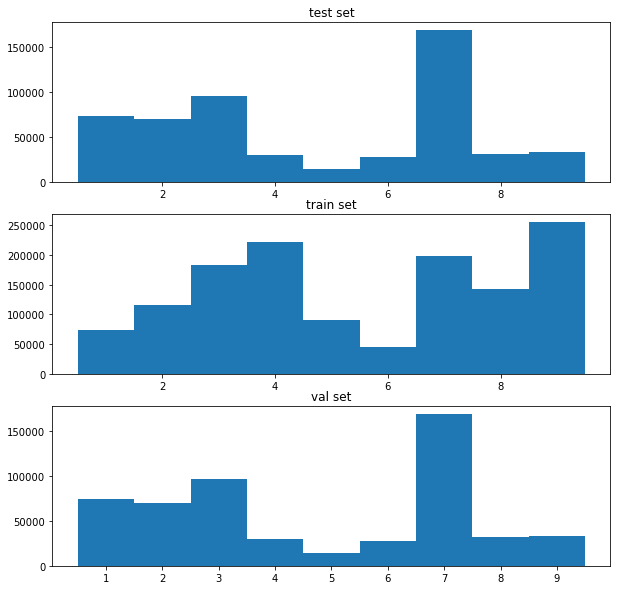

In [13]:
f, (ax1, ax2, ax3) = plt.subplots(3,1)
bins =[ x - .5 for x in range(1, 11)]
ax1.hist(y_test, bins=bins)
ax1.set_title("test set")
ax2.hist(y_train, bins=bins)
ax2.set_title("train set")
ax3.hist(y_test, bins=bins)
ax3.set_title("val set")

plt.xticks(range(1,10))
plt.show()

In [14]:
BATCH_SIZE = 512
EPOCHS = 10

In [15]:
def casted_accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(tf.add(y_pred, .5), tf.int32)
    return tf.divide(tf.reduce_sum(tf.cast(tf.equal(y_pred, y_true), tf.int32)), tf.size(y_true))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

regression_model = Sequential()
regression_model.add(Dense(1, input_dim=X_train.shape[-1]))
regression_model.compile(loss="mse", optimizer='adam', metrics=[casted_accuracy])
regression_model.summary()
with tf.device("cpu:0"):
    regression_history = regression_model.fit(
        X_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=[callback])
    results = regression_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
    print("test loss, test acc:", results)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2591/2591 [==============================] - 3s 1ms/step - loss: 108.8676 - casted_accuracy: 0.0697 - val_loss: 20.0001 - val_casted_accuracy: 0.0705
Epoch 2/10
2591/2591 [==============================] - 3s 1ms/step - loss: 11.1442 - casted_accuracy: 0.1060 - val_loss: 9.7963 - val_casted_accuracy: 0.0604
Epoch 3/10
2591/2591 [==============================] - 3s 1ms/step - loss: 7.1303 - casted_accuracy: 0.1593 - val_loss: 6.6790 - val_casted_accuracy: 0.0113
Epoch 4/10
2591/2591 [==============================] - 3s 1ms/step - loss: 6.1379 - casted_accuracy: 0.0717 - val_loss: 5.6260 - val_casted_accuracy: 0.0074
Epoch 5/10
2591/2591

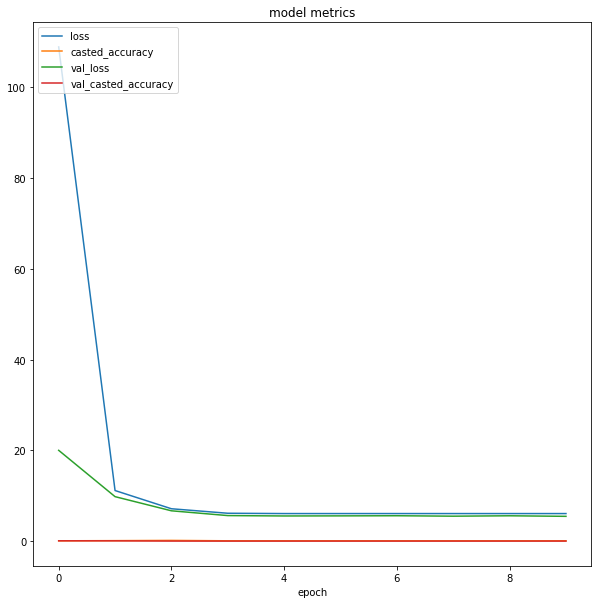

In [16]:
plot_model_history(regression_history)

In [17]:
for name, weigth in zip(feature_columns, regression_model.weights[0].numpy()):
    print(name, weigth)

print("bias", regression_model.weights[1].numpy())

perclos_combined_60s_interval [0.03]
max_blink_duration_60s_interval [0.01]
min_blink_duration_60s_interval [0.11]
mean_blink_duration_60s_interval [-0.13]
blink_counts_60s_interval [-0.05]
perclos_closed_combined [0.14]
bias [5.24]


In [18]:
# # compare accuracy when using different bins
# y_pred_raw = model.predict(X_test)

# shifts = np.linspace(-1.5, .99, 20)
# accs = list()
# for shift in shifts:
#     y_pred_digitize = digitize(y_pred_raw, shift=shift)
#     metric = tf.keras.metrics.Accuracy()
#     metric.update_state(y_true=y_test, y_pred=y_pred_digitize)
#     acc = metric.result().numpy()
#     accs.append(acc)
#     #print(f"{str(round(shift,2)).center(5)} -> {str(round(acc,2))}")

# best_shift = shifts[np.argmax(accs)]
# print(f"max acc with shift of {best_shift}")
# plt.plot(shifts, accs)
# plt.title("accuracy vs shifts in threshold for assigning class")
# plt.show()

Confusion matrix, without normalization


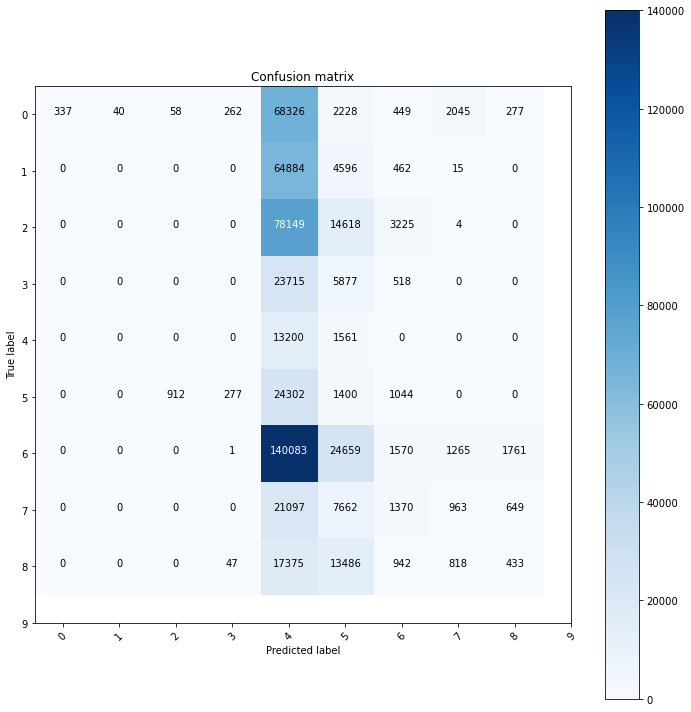

In [31]:
plot_cm_matrix(regression_model, X_test, y_test, output_kind="digitize")

### ordinal regression with sigmoid and one-hot-like encoding

In [32]:
y_test_one_hot = label_to_one_hot_like(y_test.astype(int))
y_train_one_hot = label_to_one_hot_like(y_train.astype(int))
y_val_one_hot = label_to_one_hot_like(y_val.astype(int))

In [33]:
def one_hot_like_accuracy(y_true, y_pred, threshold = .5):
    threshold = keras.backend.constant(threshold)
    y_pred = keras.backend.sum(keras.backend.cast(keras.backend.greater(y_pred,threshold), dtype=tf.int64), axis=1)
    y_true = keras.backend.sum(keras.backend.cast(keras.backend.greater(y_true,threshold), dtype=tf.int64), axis=1)
    return tf.divide(tf.reduce_sum(tf.cast(tf.equal(y_pred, y_true), tf.int32)), tf.size(y_true))

one_hot_model = Sequential()
one_hot_model.add(Dense(8, input_dim=X_train.shape[-1], activation='sigmoid'))
one_hot_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[one_hot_like_accuracy])
one_hot_model.summary()
with tf.device("cpu:0"):
    one_hot_history = one_hot_model.fit(
        X_train,
        y_train_one_hot,
        epochs=EPOCHS ,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val_one_hot), 
        callbacks=[callback])
    results = one_hot_model.evaluate(X_test, y_test_one_hot, batch_size=BATCH_SIZE)
    print("test loss, test acc: ", results)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 56        
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2591/2591 [==============================] - 5s 2ms/step - loss: 9.7799 - one_hot_like_accuracy: 0.2003 - val_loss: 10.6629 - val_one_hot_like_accuracy: 0.1604
Epoch 2/10
2591/2591 [==============================] - 6s 2ms/step - loss: 8.8125 - one_hot_like_accuracy: 0.2653 - val_loss: 10.6792 - val_one_hot_like_accuracy: 0.1018
Epoch 3/10
2591/2591 [==============================] - 4s 2ms/step - loss: 8.7980 - one_hot_like_accuracy: 0.2763 - val_loss: 10.6734 - val_one_hot_like_accuracy: 0.0919
Epoch 4/10
2591/2591 [==============================] - 4s 2ms/step - loss: 8.7969 - one_hot_like_accuracy: 0.2770 - val_loss: 10.6824 - va

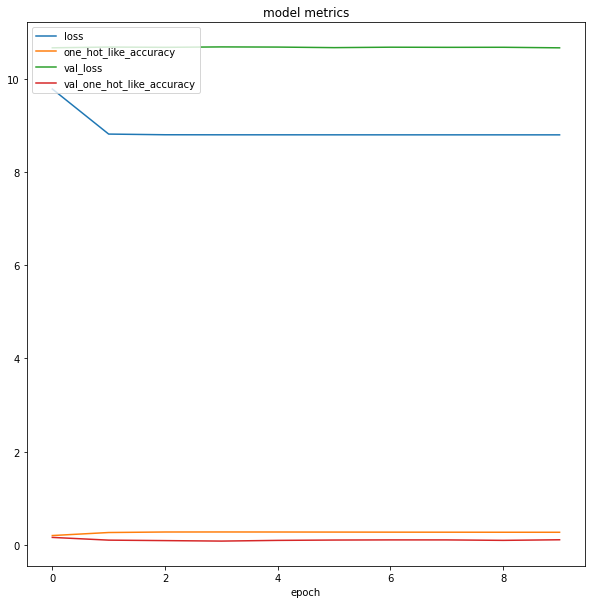

In [34]:
plot_model_history(one_hot_history)

In [35]:
y_pred_raw = one_hot_model.predict(X_test)
print(y_pred_raw.shape)

(546962, 8)


max acc with threshold of 0.26842105263157895


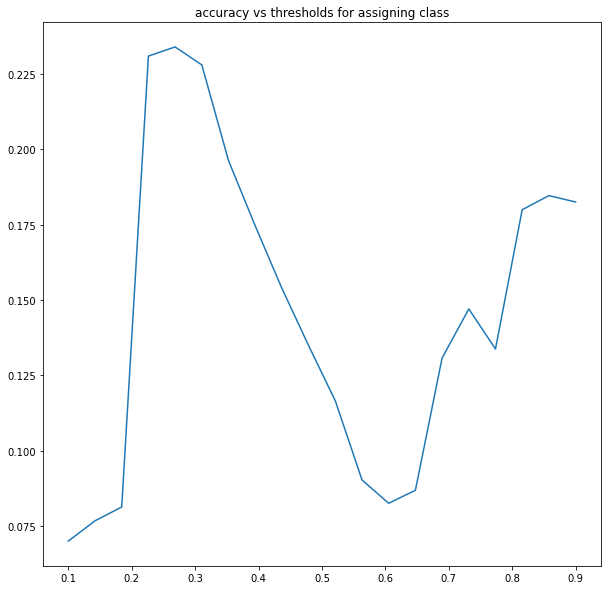

In [36]:
thresholds = np.linspace(.1,.9, 20)
accs = []
for threshold in thresholds:
    acc = one_hot_like_accuracy(y_test_one_hot, y_pred_raw, threshold=threshold)
    accs.append(acc)

best_threshold = thresholds[np.argmax(accs)]
print(f"max acc with threshold of {best_threshold}")
plt.plot(thresholds, accs)
plt.title("accuracy vs thresholds for assigning class")
plt.show()

[4 5 6 7 8]
Normalized confusion matrix


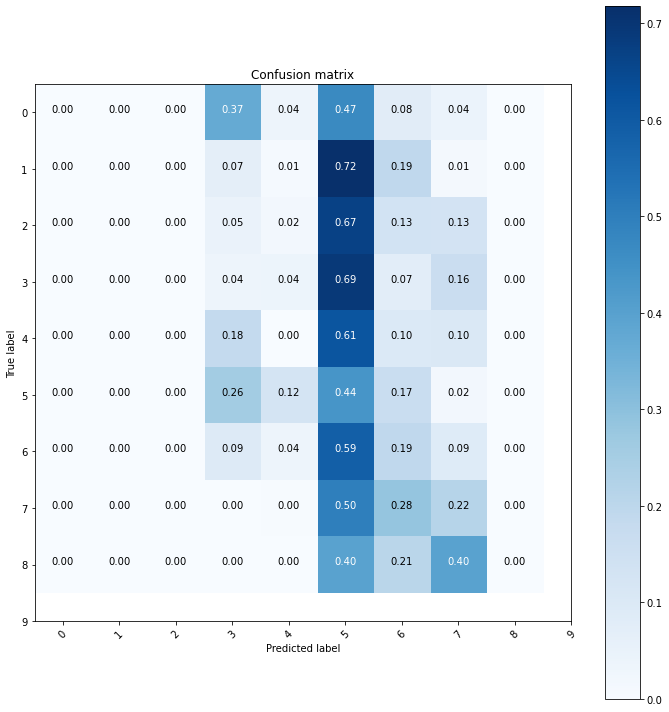

In [37]:
plot_cm_matrix(one_hot_model, X_test, y_test, output_kind="one-hot-like", threshold=best_threshold, normalize=True)

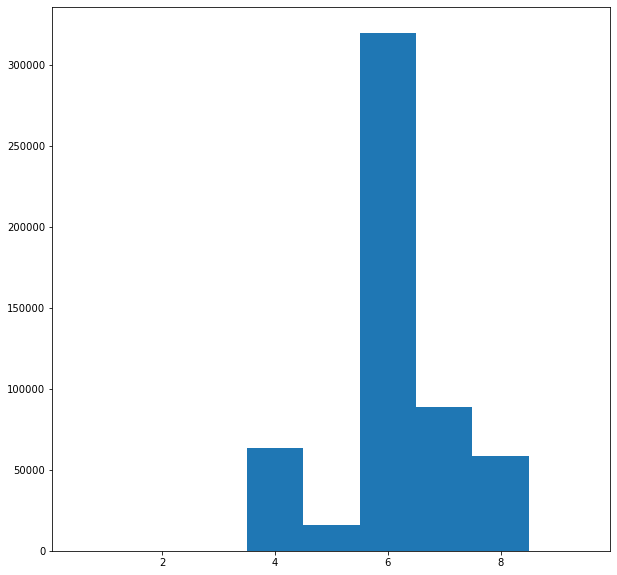

In [38]:
preds = one_hot_like_to_label(y_pred_raw, threshold=best_threshold).numpy()
plt.hist(preds, bins=bins)
plt.show()

# helper functions

In [1]:
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.precision", 2)
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import random
import math

In [2]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def plot_cm_matrix(model, X_test, y_test, output_kind="float", **kwargs):
    if "normalize" in kwargs:
        normalize = kwargs.pop("normalize")
    else:
        normalize = False

    y_pred = model.predict(X_test)

    if output_kind == "float":
        y_pred = np.array(y_pred).astype(int)
    elif output_kind == "digitize":
        y_pred = digitize(y_pred, **kwargs)
    elif output_kind == "one-hot-like":
        y_pred = one_hot_like_to_label(y_pred, **kwargs)
        # print(np.unique(y_pred))
    elif output_kind == "scores":
        y_pred = np.argmax(y_pred, axis=-1)
    else:
        raise ValueError(f"kind {output_kind} unkown.")

    c_matrix = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(c_matrix, classes=list("0123456789"), normalize=normalize)

def plot_model_history(history):
    for key in history.history:
        plt.plot(history.history[key])
    plt.title('model metrics')
    plt.xlabel('epoch')
    plt.legend(list(history.history.keys()), loc='upper left')
    plt.show()

In [3]:

def digitize(arr, shift: float = .5, label_start_index: int = 1):
    bins = [x + shift for x in range(1,9)]
    return np.digitize(arr, bins=bins) + label_start_index

def one_hot_like_to_label(arr, threshold=.5):
    threshold = keras.backend.constant(threshold)
    y_pred_sum = keras.backend.sum(keras.backend.cast(keras.backend.greater(arr,threshold), dtype=tf.int64), axis=1)
    return y_pred_sum


def label_to_one_hot_like(arr):
    arr = np.squeeze(arr)
    k = 8
    one_hots = np.zeros(shape=(len(arr), k), dtype=int)
    for i, element in enumerate(arr):
        one_hots[i, :element - 1] = 1
    return one_hots


In [ ]:
f67fc16d581767c030b6f191cf650c3a69d9ed5d

In [ ]:
f67fc16d581767c030b6f191cf650c3a69d9ed5d

In [ ]:
f67fc16d581767c030b6f191cf650c3a69d9ed5d

In [ ]:
f67fc16d581767c030b6f191cf650c3a69d9ed5d

In [ ]:
f67fc16d581767c030b6f191cf650c3a69d9ed5d

In [ ]:
f67fc16d581767c030b6f191cf650c3a69d9ed5d

In [ ]:
f67fc16d581767c030b6f191cf650c3a69d9ed5d

In [4]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [5]:
1

1

# Different notes

### session types mapping:  
a -> 0  
b -> 1  
s -> 18

In [27]:
int(1.9)

1

In [192]:
[x -.5 for x in range(1,9)]

[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]

In [197]:
a = [1.4, 1.6, 0.49]
print([int(b + .5)for b in a])

[1, 2, 0]


In [200]:
K.cast(1.9, dtype=tf.int16)

<tf.Tensor: shape=(), dtype=int16, numpy=1>

In [206]:
K.bias_add(tf.constant([[1],[2],[3]]), bias=tf.constant([1]))

<tf.Tensor: shape=(3, 1), dtype=int32, numpy=
array([[2],
       [3],
       [4]], dtype=int32)>

In [210]:
K.update_add(tf.constant([[1],[2],[3]]), tf.constant([1]))

AttributeError: AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'assign_add'

In [211]:
tf.add([1,2,3], 1)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([2, 3, 4], dtype=int32)>